# Mobile Price Classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Data Exploration

In [2]:
train = pd.read_csv('train.csv')
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

## Data Preparation

In [4]:
# check missing values
train.isna().sum().sort_values(ascending = False)

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [5]:
# check duplicates
train[train.duplicated() == True].sum()

battery_power    0.0
blue             0.0
clock_speed      0.0
dual_sim         0.0
fc               0.0
four_g           0.0
int_memory       0.0
m_dep            0.0
mobile_wt        0.0
n_cores          0.0
pc               0.0
px_height        0.0
px_width         0.0
ram              0.0
sc_h             0.0
sc_w             0.0
talk_time        0.0
three_g          0.0
touch_screen     0.0
wifi             0.0
price_range      0.0
dtype: float64

In [6]:
# check outliers
train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


### Example of ourliers

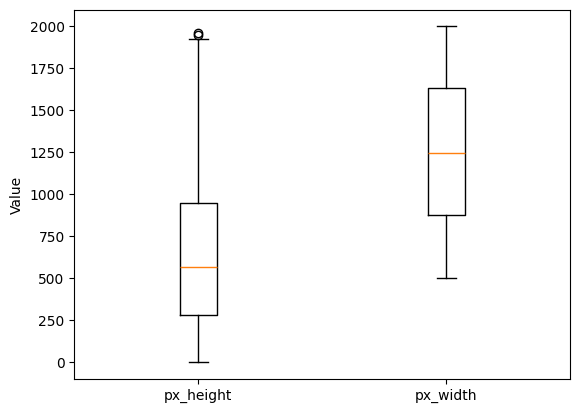

In [7]:
plt.boxplot(train[['px_height', 'px_width']])
plt.ylabel('Value')
plt.xticks([1, 2], ['px_height', 'px_width'])
plt.show()

### Remove outliers

In [8]:
train_before = train.drop(columns = 'price_range')

lower_cap = train_before.quantile(0.01)
upper_cap = train_before.quantile(0.99)

train_capped = train_before.apply(lambda x: np.where(x < lower_cap[x.name], lower_cap[x.name],
                                    np.where(x > upper_cap[x.name], upper_cap[x.name], x)))

train_capped = train_before.merge(train[['price_range']], left_index = True, right_index = True)
train_capped

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


## Data Visualization

In [32]:
print(train[['price_range']].value_counts())
print(train[['price_range']].value_counts(normalize = True))

price_range
0              500
1              500
2              500
3              500
Name: count, dtype: int64
price_range
0              0.25
1              0.25
2              0.25
3              0.25
Name: proportion, dtype: float64


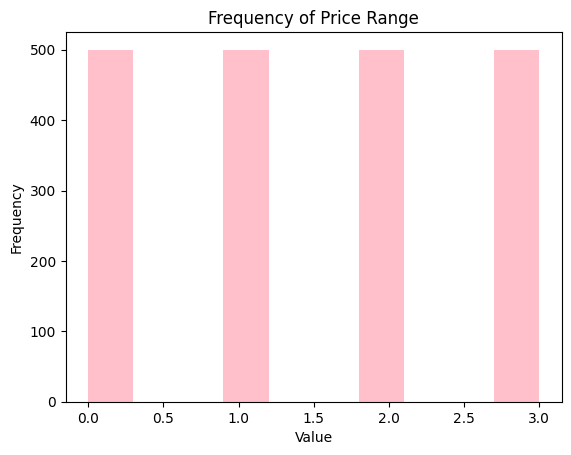

In [37]:
plt.hist(train_capped['price_range'], color='pink')
plt.title('Frequency of Price Range')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Hence, balanced dataset

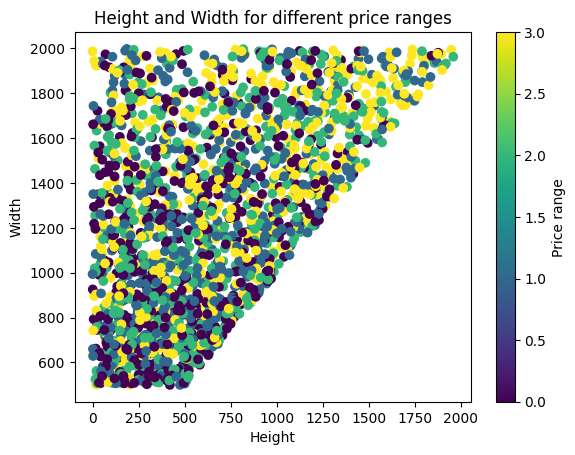

In [10]:
plt.scatter(train_capped['px_height'], train_capped['px_width'], c = train_capped['price_range'])
plt.title('Height and Width for different price ranges')
plt.xlabel('Height')
plt.ylabel('Width')
plt.colorbar(label = 'Price range') 
plt.show()

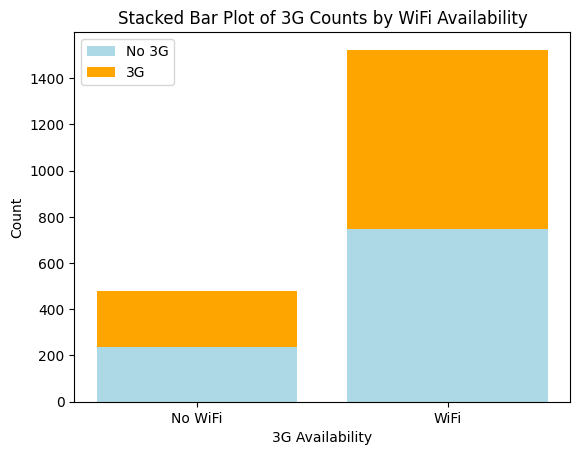

In [11]:
# Count occurrences of three_g for both wifi == 0 and wifi == 1
three_g_0_count = train_capped[train_capped['wifi'] == 0]['three_g'].value_counts().sort_index()
three_g_1_count = train_capped[train_capped['wifi'] == 1]['three_g'].value_counts().sort_index()

labels = ['No WiFi', 'WiFi']
x = range(len(labels))

plt.bar(x, three_g_0_count, label='No 3G', color = 'lightblue')
plt.bar(x, three_g_1_count, bottom= three_g_0_count, label='3G', color = 'orange')
plt.xticks(x, labels)
plt.title('Stacked Bar Plot of 3G Counts by WiFi Availability')
plt.xlabel('3G Availability')
plt.ylabel('Count')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

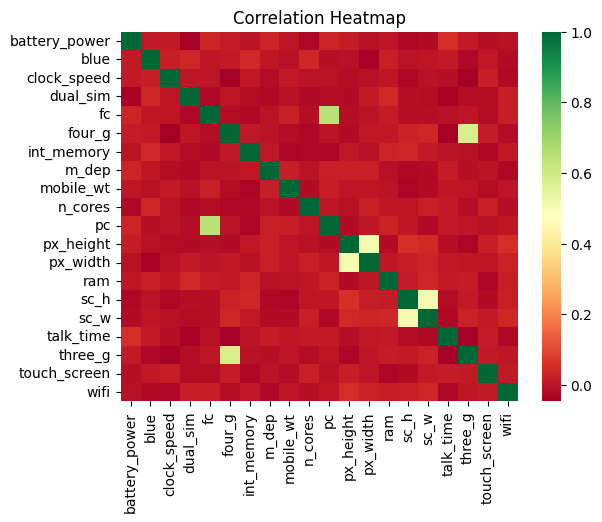

In [12]:
sns.heatmap(train_capped.drop(columns = 'price_range').corr(), cmap = 'RdYlGn')
plt.title('Correlation Heatmap')

Since Lasso regression is influenced by relationships between variables, which may include correlations, it will unlikely be able to help us in feature selection

## Feature Selection by Lasso Regression
### Using GridSearchCV to find best parameter for Lasso Regression

In [13]:
X = train_capped.drop(columns = 'price_range')
y = train_capped[['price_range']]

X_feature = X.values
y_feature = y.values
names = train_capped.drop(columns = 'price_range').columns

# parameters to be tested on GridSearchCV
params = {"alpha": np.linspace(0.00001, 10, 500)}

# setting KFold for Cross validation
kf = KFold(n_splits = 6, shuffle = True, random_state = 2024)

# Instantiate a lasso regression model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv = GridSearchCV(lasso, param_grid = params, cv = kf)
lasso_cv.fit(X, y)
print(f"Best Alpha for Lasso Regression: {lasso_cv.best_params_['alpha']}")

Best Alpha for Lasso Regression: 0.04009012024048097


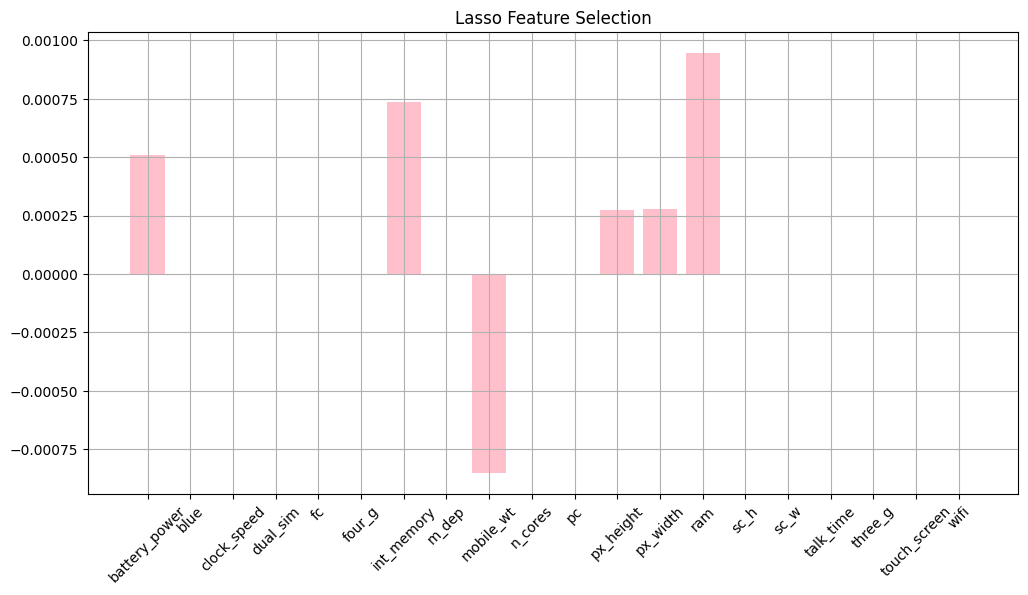

In [14]:
lasso = Lasso(alpha = lasso_cv.best_params_['alpha'])
lasso.fit(X_feature, y_feature) 
lasso_coef = lasso.coef_

plt.figure(figsize=(12, 6))
plt.bar(names, lasso_coef, color = 'pink')
plt.grid()
plt.title('Lasso Feature Selection')
plt.xticks(rotation=45)
plt.show()

## Data Prediction

### Logistic Regression model

In [15]:
X = train_capped[['battery_power', 'int_memory', 'mobile_wt', 'ram', 'px_height', 'px_width']]
y = train_capped['price_range']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 23, stratify = y)

##### Due to the capability of our device, we can only afford this number of maximum iterations

In [16]:
log_reg = LogisticRegression(max_iter = 10000)
log_reg_cv_scores = cross_val_score(log_reg, X_train, y_train.to_numpy(), cv=kf)

C:\Users\Terra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
print(f'Accuracy of Logistic Regression Model for train dataset: {log_reg_cv_scores}')
print(f'Mean Accuracy for train dataset: {log_reg_cv_scores.mean()}')

Accuracy of Logistic Regression Model for train dataset: [0.97008547 0.96153846 0.97854077 0.97854077 0.97424893 0.98283262]
Mean Accuracy for train dataset: 0.974297836958781


In [18]:
log_reg.fit(X_train, y_train.to_numpy())

LogisticRegression(max_iter=10000)

In [19]:
print(f'Accuracy of Logistic Regression Model for test dataset: {log_reg.score(X_test, y_test)}')

Accuracy of Logistic Regression Model for test dataset: 0.975


### KNeighborsClassifier model

In [20]:
knn = KNeighborsClassifier(n_neighbors = 6)
knn_cv_scores = cross_val_score(knn, X_train, y_train.to_numpy(), cv = kf)

In [21]:
print(f'Accuracy of KNeighborsClassifier Model for train dataset: {knn_cv_scores}')
print(f'Mean Accuracy for TRAIN dataset: {knn_cv_scores.mean()}')

Accuracy of KNeighborsClassifier Model for train dataset: [0.93162393 0.90598291 0.92274678 0.91416309 0.92274678 0.90128755]
Mean Accuracy for TRAIN dataset: 0.9164251739359036


In [22]:
knn.fit(X_train, y_train.to_numpy())

KNeighborsClassifier(n_neighbors=6)

In [23]:
print(f'Accuracy of KNeighborsClassifier Model for TEST dataset: {knn.score(X_test, y_test)}')

Accuracy of KNeighborsClassifier Model for TEST dataset: 0.91


### RandomForest model

In [24]:
param_forest = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

forest = RandomForestClassifier()
forest_grid = RandomizedSearchCV(estimator=forest, param_distributions=param_forest, n_iter=100, cv=kf, verbose=0, random_state=2024, n_jobs=-1)
forest_grid.fit(X_train, y_train.to_numpy())
print(forest_grid.best_params_)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': True}


In [25]:
best_forest = forest_grid.best_estimator_
print(f'Accuracy of RandomForest Model for TEST dataset: {best_forest.score(X_test, y_test)}')

Accuracy of RandomForest Model for TEST dataset: 0.9016666666666666


#### Feature Importance

In [26]:
feature_importance = best_forest.feature_importances_
feature = X.columns

# Create dataframe for visualization
feature_df = pd.DataFrame({
    'Feature': feature,
    'Importance': feature_importance
    }).sort_values(by = 'Importance', ascending = False)

feature_df

,Feature,Importance
3,ram,0.660329
0,battery_power,0.103569
4,px_height,0.078357
5,px_width,0.076685
2,mobile_wt,0.042520
1,int_memory,0.038541


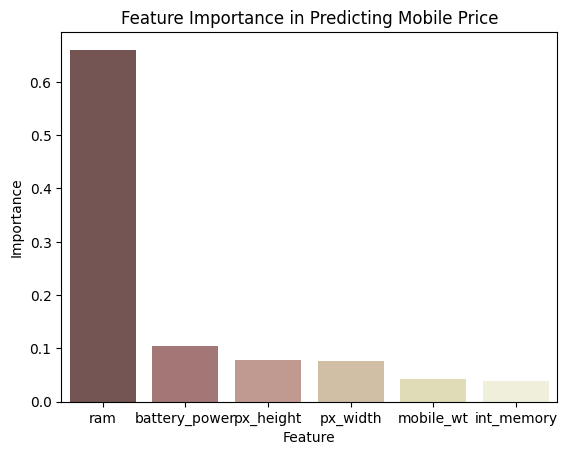

In [27]:
palette = sns.color_palette('pink', n_colors = len(feature_df))
sns.barplot(x = feature_df['Feature'], y = feature_df['Importance'], hue=feature_df['Feature'], palette=palette, legend=False)
plt.title('Feature Importance in Predicting Mobile Price')
plt.show()